# Approfondimento di RAG (CromaDB)

A seguito dei pessimi risultati conseguiti dal RAG nel precedente notebook, provo ad approfondire RAG utilizzando sempre ChromaDB ma con un diverso embedding model (nomic-embed-text)

In [1]:
!ollama list

NAME                                   ID              SIZE      MODIFIED     
nomic-embed-text:latest                0a109f422b47    274 MB    2 hours ago     
erwan2/DeepSeek-Janus-Pro-7B:latest    253d552064e2    4.2 GB    7 hours ago     
MFDoom/deepseek-r1-tool-calling:7b     2410129d448f    4.7 GB    2 days ago      
deepseek-r1:latest                     0a8c26691023    4.7 GB    4 days ago      
qwen2.5-coder:3b                       e7149271c296    1.9 GB    2 weeks ago     
sqlcoder:latest                        77ac14348387    4.1 GB    2 months ago    
llama3.2-vision:latest                 38107a0cd119    7.9 GB    2 months ago    
llama3.2:3b-instruct-fp16              195a8c01d91e    6.4 GB    4 months ago    
llama3.2:latest                        a80c4f17acd5    2.0 GB    4 months ago    


RAG (Retrieval Augmented Generation) è una tecnica utilizzata insieme ai Large Language Models (LLM) per migliorarne le prestazioni, in particolare nella generazione di risposte o informazioni accurate e pertinenti.

E' composto di 2 componenti:
- Retrieval Componemt : comporta il recupero di documenti o informazioni rilevanti da un database o corpus di grandi dimensioni. Il sistema di recupero utilizza una query (spesso generata dal prompt o dalla domanda di input) per trovare le informazioni più rilevanti da un insieme di documenti, basi di conoscenza o altre fonti.

- Generation Component : utilizza un LLM pre-trained (in questo caso un LLM ospitati da Ollama.) a cui fornisce in input le informazioni recuperate nella prima fase per produrre una risposta coerente e contestualmente appropriata.

In [2]:
# import section
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
import ollama

# FASE 1 : PRE-PROCESS DEI DOCUMENTI SU CUI VERRA' FATTO RAG

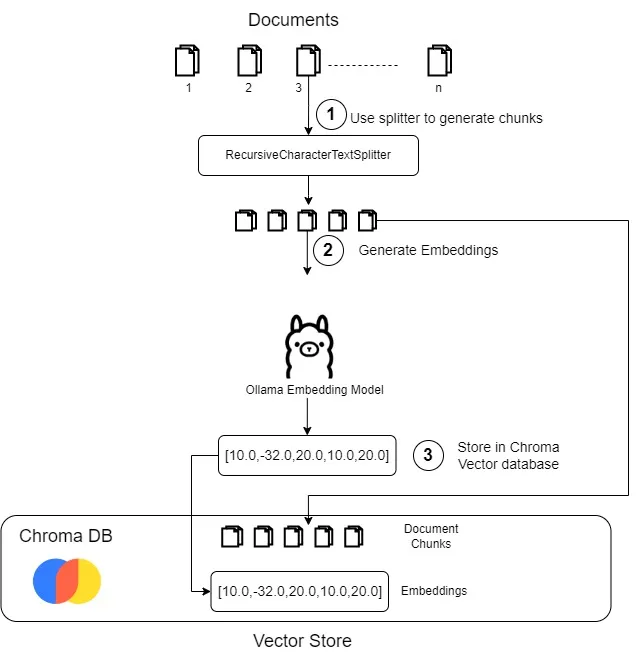![image.png]

In [3]:
# Load local pdf file monopoly.pdf
file_path_local='monopoly.pdf'
#pdf_loader = UnstructuredPDFLoader(file_path=file_path_local)
pdf_loader = PyMuPDFLoader(file_path_local)
data = pdf_loader.load()
pdf_data = pdf_loader.load()
print("pdf data loaded...")

pdf data loaded...


In [4]:
# Chunking of data where chunk_size, chunk_overlap is configurble and defined as per data document & use case
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
data_chunks = text_splitter.split_documents(pdf_data)
print("data chunks created....")

data chunks created....


In [5]:
# Store chunks and embeddings received from ollama embedding model in chroma database
# For this example Embedding model is nomic-embed-text
vectorstore = Chroma.from_documents(data_chunks,
                      OllamaEmbeddings(model="nomic-embed-text"),
                      persist_directory="./chroma_db",
                      collection_name='local_rag_db')

Una volta che i documenti sono stati archiviati nel vector store si può passare alla seconda fase del processo

# FASE 2 : RETRIEVAL
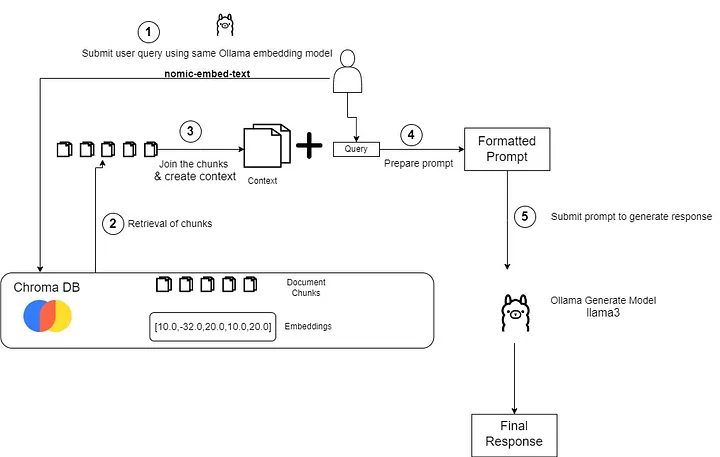

In [6]:
question="Quando si va in prigione?"

retriever = vectorstore.as_retriever()
retrieved_docs = retriever.invoke(question)
print(f"Estratti {len(retrieved_docs)} documenti")


Estratti 4 documenti


In [7]:
def combine_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [9]:
formatted_content = combine_docs(retrieved_docs)
print(formatted_content)

3) 
Ottiene 
per 
tre 
volte 
di 
seguito 
un 
punteggio 
doppio 
con 
i dadi. 
La PRIGIONE è collocata nella stessa casella del TRANSITO. Chi è condannato alla Prigione ci va direttamente e 
senza mai passare dal VIA!, il che significa che non riceve € 500 di indennità. Se un giocatore capita sulla casella 
della Prigione in seguito ad un normale lancio di dadi, vi resta soltanto come visitatore in transito e, al proprio turno, 
prosegue. 
Chi 
si 
trova 
in 
PRIGIONE 
può 
uscirne 
in 
uno

al prezzo pieno). Il prezzo di partenza per l’asta è di € 5 per qualsiasi proprietà. Chi entra in possesso di una 
proprietà riceve dalla Banca il relativo contratto che ne prova l’acquisto e che deve essere posto sul tavolo in modo 
ben visibile a tutti, con la 
parte colorata rivolta verso l’alto. 
Fermata su proprietà aggiudicata 
Quando un giocatore si ferma su una proprietà di un avversario, deve pagare al proprietario l’affitto indicato sul

prosegue. 
Chi 
si 
trova 
in 
PRIGIONE 
può 
usci

In [10]:
import re

def ollama_llm(question, context):

    formatted_prompt = f"Question: {question}\n\nContext: {context}"
#    print(f"Richiamo il modello con {formatted_prompt}")
    response = ollama.chat(model="llama3.2", messages=[{'role': 'system', 'content': "Rispondi sempre in italiano"},
                                                          {'role': 'user', 'content': formatted_prompt}])
    response_content = response['message']['content']
    
    # Remove content between <think> and </think> tags to remove thinking output
    final_answer = re.sub(r'<think>.*?</think>', '', response_content, flags=re.DOTALL).strip()
    return final_answer

In [11]:
response = ollama_llm(question, formatted_content)
print(response)

La risposta alla domanda "Quando si va in prigione?" è:

1) Se il segnalino termina sulla casella "IN PRIGIONE!" 

2) Se pesca un cartoncino PROBABILITÀ o IMPREVISTI sul quale è scritto di andare in prigione.
